In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the dataset
train_data = np.load('Available data/train_data.npy')
train_data_split = np.load('Available data/train_data_split.npy')
test_data = np.load('Available data/test_data.npy')
test_data_split = np.load('Available data/test_data_split.npy')
train_label = np.load('Available data/train_label.npy')
test_label = np.load('Available data/test_label.npy')

EEG_type = ['delta', 'theta', 'alpha', 'beta', 'gamma']

train_data.shape, test_data.shape, train_data_split.shape, test_data_split.shape, train_label.shape, test_label.shape

((72360, 310),
 (49824, 310),
 (5, 72360, 62),
 (5, 49824, 62),
 (72360,),
 (49824,))

### Fisrt, we train our model with whole types of EEG features(Differential entropy), and see the performance

In order to select the number of components that explain at least 90% of the explained variance, we need to pick 18 components


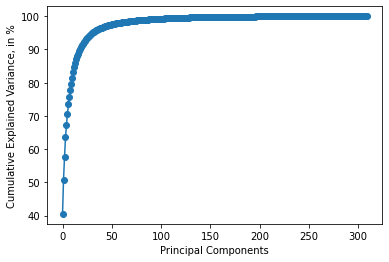

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# Dimension reduction
pca = Pipeline([('scaler', StandardScaler()),
                ('PCA', PCA(n_components=310))])

pca.fit(train_data)

num_to_choose = np.where(np.cumsum(pca.named_steps['PCA'].explained_variance_ratio_)>0.9)[0][0]

print('In order to select the number of components that explain at least 90% of the explained variance, we', 
      'need to pick {} components'.format(num_to_choose))

plt.plot(100*np.cumsum(pca.named_steps['PCA'].explained_variance_ratio_), '-o')
plt.xlabel('Principal Components',size=10)
plt.ylabel('Cumulative Explained Variance, in %', size=10);

In [4]:
# KNN classifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_pca = Pipeline([('scaler', StandardScaler()),
                    ('PCA', PCA(n_components=num_to_choose)),
                    ('classifier', KNeighborsClassifier())])

knn_pca.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('PCA', PCA(n_components=18)),
  ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'PCA': PCA(n_components=18),
 'classifier': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': 18,
 'PCA__n_oversamples': 10,
 'PCA__power_iteration_normalizer': 'auto',
 'PCA__random_state': None,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False,
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [5]:
# Gridsearch for number of neighbors
n_neighbors = [i for i in range(3,11)]
param_grid = {'classifier__n_neighbors': n_neighbors}
model_grid = GridSearchCV(knn_pca,
                          param_grid=param_grid,
                          cv=10,
                          scoring='accuracy', 
                          refit=True)


In [6]:
model_grid.fit(train_data, train_label)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('PCA', PCA(n_components=18)),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [7]:
print(model_grid.best_params_)

{'classifier__n_neighbors': 6}


In [8]:
# Performance for KNN with PCA
from sklearn.metrics import accuracy_score

knn_pca = model_grid.best_estimator_

y_test = knn_pca.predict(test_data)
y_train = knn_pca.predict(train_data)

print('Accuracy in train data: ', accuracy_score(train_label, y_train))
print('Accuracy in test data: ', accuracy_score(test_label, y_test))

Accuracy in train data:  1.0
Accuracy in test data:  0.6966321451509313


In [12]:
# KNN without PCA and its performance
knn = Pipeline([('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=6))])

knn.fit(train_data, train_label)

y_train = knn.predict(train_data)
y_test = knn.predict(test_data)

print('Accuracy in train data: ', accuracy_score(train_label, y_train))
print('Accuracy in test data: ', accuracy_score(test_label, y_test))

Accuracy in train data:  1.0
Accuracy in test data:  0.7268986833654464


### Second, we split the data into our five types of EEG signal, and compare their performance

In [13]:
# Define a function to do the model train and performance evaluation
def knn_estimator(data, label, n_neighbors=6):
    
    knn = Pipeline([('scaler', StandardScaler()),
                    ('classifier', KNeighborsClassifier(n_neighbors=n_neighbors))])
    knn.fit(data, label)
    
    return knn

def knn_evaluator(name, model, train, test, t_train=train_label, t_test=test_label):
    
    y_train = model.predict(train)
    y_test = model.predict(test)
    
    print('---------------------------------------------')
    print('For '+name+' band EEG signal')
    print('Accuracy in train data: ', accuracy_score(t_train, y_train))
    print('Accuracy in test data: ', accuracy_score(t_test, y_test))
    print('---------------------------------------------')

In [14]:
for i in range(len(EEG_type)):
    
    data_train = train_data_split[i,:,:]
    data_test = test_data_split[i,:,:]
    model = knn_estimator(data_train, train_label)
    knn_evaluator(name=EEG_type[i], model=model, train=data_train, test=data_test)
    


---------------------------------------------
For delta band EEG signal
Accuracy in train data:  1.0
Accuracy in test data:  0.5529865125240848
---------------------------------------------
---------------------------------------------
For theta band EEG signal
Accuracy in train data:  1.0
Accuracy in test data:  0.5657715157353885
---------------------------------------------
---------------------------------------------
For alpha band EEG signal
Accuracy in train data:  1.0
Accuracy in test data:  0.5707490366088632
---------------------------------------------
---------------------------------------------
For beta band EEG signal
Accuracy in train data:  1.0
Accuracy in test data:  0.6762604367373154
---------------------------------------------
---------------------------------------------
For gamma band EEG signal
Accuracy in train data:  1.0
Accuracy in test data:  0.6942638086062941
---------------------------------------------
